In [1]:
# Pytorch implementation of SNN with backpropagation which engenders Hebbian Learning
import os 
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from data_mnist import download_mnist
import torch.nn.functional as F
# dataset chosen for now is mnist

def download_mnist(data_path) : 
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set


In [2]:
# A simple SNN model implementation

## In SNNs, A time axis exists and the NN sees data through time, also the activation
# functions are spikes instead of values and these spikes are raised past a certain 
# pre-activation threshold. 

# The pre-activation values constantly fades if the neurons aren't excited enough.(This
# is important as without fading, these past values may influence a spike when even it should
# be not there due to their additional support to incoming input activation value )

# The neurons after accumlating enough input activation through surpass the threshold causes
# them to "spike" and after this "spike" the neuron empties itself from it's activation and fires
# Once empty it goes to a "refactroy period" where the activation value is in -ve and this
# is here because it neuron (even biologically) takes a bit time before going into state of capable of
# firing again ( This is important as without it, if say another high input activation comes it will fire/spike
# instantaneously which rules out the whole biological imitation scenario )



class SpikingNeuronLayer(nn.Module):

    def __init__(self, device, n_inputs = 28*28, n_hidden = 100, decay_multiplier = 0.9, threshold=2.0, penalty_threshold = 2.5):
        super(SpikingNeuronLayer, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold

        self.fc = nn.Linear(n_inputs, n_hidden)

        # initializations
        self.init_parameters()
        self.reset_state()
        self.to(self.device)

    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
    
    def reset_state(self):
        # Initialization/resetting the state for each neuron when starting predictions
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)


    def forward(self, x):

        """ Forward step of neuron calling at every time step
        x : activated neurons below 
        return : a tuple of (state, output) for each time step, 
        Each tuple is having items which are of shape (batch_size, n_hidden)
        Total shape if casted : (2, batch_size, n_hidden)
        """
        if self.prev_inner.dim()==1 : 
            # Stacking a batch_size dimension after the reset_state()
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        # Firstly, Weight matrix multiplied by input x 
        # As x was modified to flickering randomly through time or else x is 
        # already output of lower deep spiking layer
        input_excitation = self.fc(x)
        
        # Adding the result to decayed version of information we aready had at previous time step
        # The decay_multiplier serves the purpose of slowly fading the inner activation such that 
        # we don’t accumulate stimulis for too long to be able to have the neurons to rest.
        inner_excitation = input_excitation +  self.prev_inner * self.decay_multiplier
        
        # Computing activations of neuron to find it's output but before activation, we have 
        # a negative bias that refrain thing from firing too much. 
        outer_excitation = F.relu(inner_excitation - self.threshold)

        # If neuron fires then we need to reset it by subtracting it's activation to get it back to inner state 
        # plus a additional penalty for increasing the "refactory period"
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate

        # Setting internal values before returning
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation

        # returning previous output
        return delayed_return_state,delayed_return_output



class InputDataToSpikingLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
    
    def reset_state(self):
        pass
    
    def forward(self, x, is_2D = True):
        # Flattening 2d image to 1d for fc layer
        x = x.view(x.size(0),-1)
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        # attaching a random mask over the input x to have flickiring random input
        return random_activation_perceptron * x
        

class OutputDataToSpikingLayer(nn.Module):

    def __init__(self, average_output = True):

        """ average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingLayer,self).__init__()
        if average_output : 
            self.reducer = lambda x, dim : x.sum(dim = dim)
        else:
            self.reducer = lambda x, dim : x.mean(dim = dim)

    def forward(self,x):
        if type(x)==list:
            x = torch.stack(x)
        return self.reducer(x,0)

class SpikingNet(nn.Module):

    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval

        self.input_conversion = InputDataToSpikingLayer(device)

        self.layer1 = SpikingNeuronLayer(
                device, n_inputs = 28 * 28 , n_hidden =100, decay_multiplier = 0.9, 
                threshold = 1.0, penalty_threshold = 1.5
                )

        self.layer2 = SpikingNeuronLayer(
                device, n_inputs = 100, n_hidden = 10, decay_multiplier = 0.9, 
                threshold = 1.0, penalty_threshold = 1.5
                )
        self.output_conversion = OutputDataToSpikingLayer(average_output = False) # sum on outputs

        # self.to(self.device)

    def forward_through_time(self, x) :
        
        """ This acts as a layer. input and output is non-time related, All time iterations
        happen inside and returned layer is thus passed through global average pooling on 
        time axis before the return such as to be able to mix this pipeline with regular backprop
        layers such as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []

        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []

        for _ in range(self.n_time_steps) : 
            xi = self.input_conversion(x)

            # For layer1 we take regular output
            layer1_state,layer1_output = self.layer1(xi)
            
            layer2_state, layer2_output = self.layer2(layer1_output)

            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)

            # we take inner state of layer2 because it's pre-activation and thus acts as out logits
            out.append(layer2_state)

        out = self.output_conversion(out[self.begin_eval : ])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]

    def forward(self,x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim = -1)

    def visualize_all_neurons(self,x) : 
 
        assert x.shape[0] == 1 and len(x.shape) == 4, (
                "Pass only 1 example to SpikingNet.visualize(x)  with outer dim shape of 1")

        _, layers_state = self.forward_through_time(x)
        
        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
       

    def visualize_neuron(self,x, layer_idx, neuron_idx):

        assert x.shape[0] == 1 and len(x.shape) == 4, (
                "Pass only 1 example to SpikingNet.visualize(x)  with outer dim shape of 1")

        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        
        layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        # Plot 'em
        self.plot_neuron(layer_state[neuron_idx], title = "Inner state values of neuron {} of layer {}".format(neuron_idx,layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title) : 

        width = max(16, layer_values.shape[0]/8)
        height = max(4, layer_values.shape[1]/8)
        plt.figure(figsize = (width,height))
        plt.imshow(
                layer_values,
                interpolation = "nearest",
                cmap = plt.cm.rainbow
                )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self,neuron_through_time,title):

        width = max(16, len(neuron_through_time)/8)
        height = 4
        plt.figure(figsize = (width,height))

        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neurons's activation")
        plt.show()



## A  Non - Spiking Neural Network for comparison purposes
class NonSpikingNet(nn.Module):

    def __init__(self) : 
        super(NonSpikingNet,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
                nn.Linear(28*28,100),
                nn.ReLU(),
                nn.Linear(100,10),
        )

    def forward(self,x) : 
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return F.log_softmax(logits,dim = -1)




/home/waveandsmile/anaconda3/envs/deep/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch : 1 [0/60000 (0%)] Loss : 2.404060 Accuracy : 6.60%
Train Epoch : 1 [10000/60000 (17%)] Loss : 2.036748 Accuracy : 32.40%
Train Epoch : 1 [20000/60000 (33%)] Loss : 2.004225 Accuracy : 45.60%
Train Epoch : 1 [30000/60000 (50%)] Loss : 0.647523 Accuracy : 79.50%
Train Epoch : 1 [40000/60000 (67%)] Loss : 0.566007 Accuracy : 83.50%
Train Epoch : 1 [50000/60000 (83%)] Loss : 0.411770 Accuracy : 87.00%


/home/waveandsmile/anaconda3/envs/deep/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set : Average Loss : 0.4443, Accuracy : 8530/10000 (85.30%) 

Train Epoch : 2 [0/60000 (0%)] Loss : 0.453817 Accuracy : 84.00%
Train Epoch : 2 [10000/60000 (17%)] Loss : 0.379799 Accuracy : 88.80%
Train Epoch : 2 [20000/60000 (33%)] Loss : 0.361238 Accuracy : 89.50%
Train Epoch : 2 [30000/60000 (50%)] Loss : 0.379335 Accuracy : 89.40%
Train Epoch : 2 [40000/60000 (67%)] Loss : 0.370158 Accuracy : 87.80%
Train Epoch : 2 [50000/60000 (83%)] Loss : 0.324336 Accuracy : 90.40%

Test set : Average Loss : 0.3361, Accuracy : 9022/10000 (90.22%) 

Train Epoch : 3 [0/60000 (0%)] Loss : 0.337714 Accuracy : 89.70%
Train Epoch : 3 [10000/60000 (17%)] Loss : 0.333106 Accuracy : 90.10%
Train Epoch : 3 [20000/60000 (33%)] Loss : 0.332338 Accuracy : 91.10%
Train Epoch : 3 [30000/60000 (50%)] Loss : 0.348455 Accuracy : 89.40%
Train Epoch : 3 [40000/60000 (67%)] Loss : 0.371390 Accuracy : 89.50%
Train Epoch : 3 [50000/60000 (83%)] Loss : 0.316726 Accuracy : 90.70%

Test set : Average Loss : 0.3240,

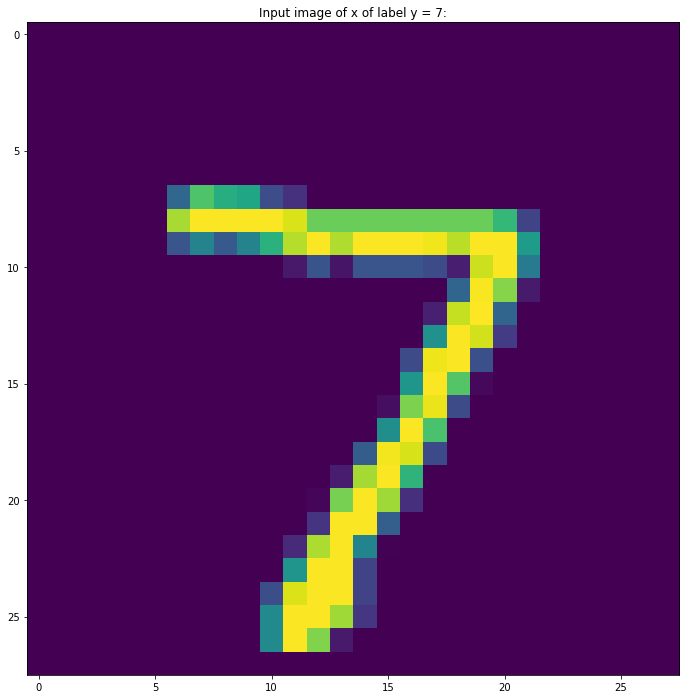

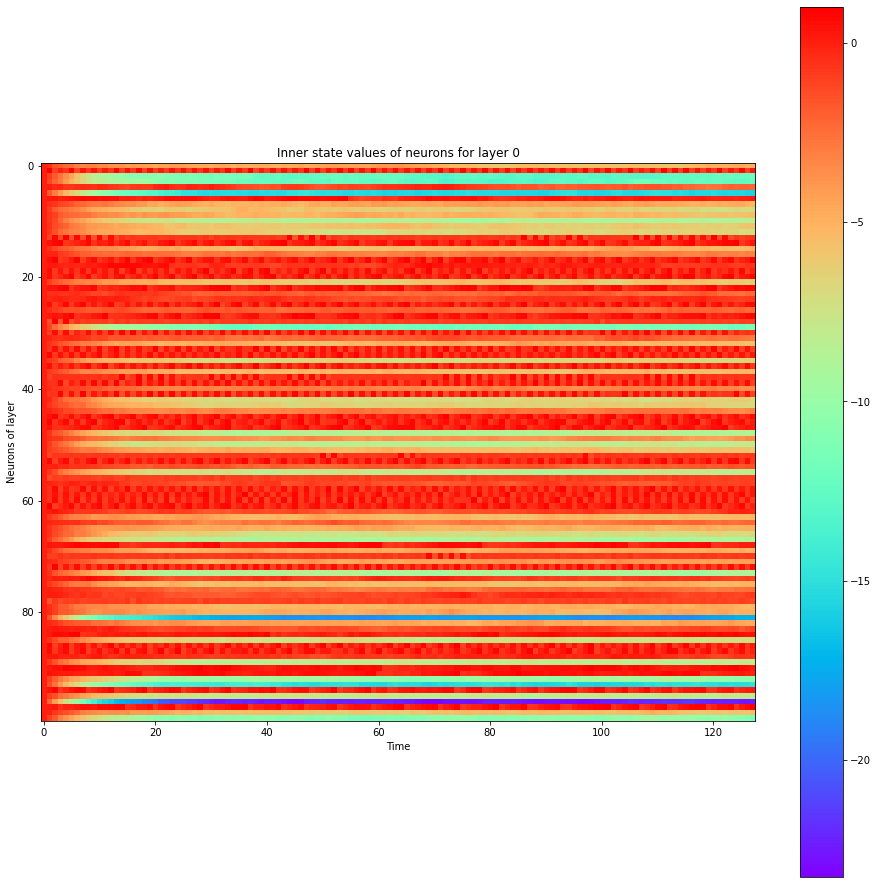

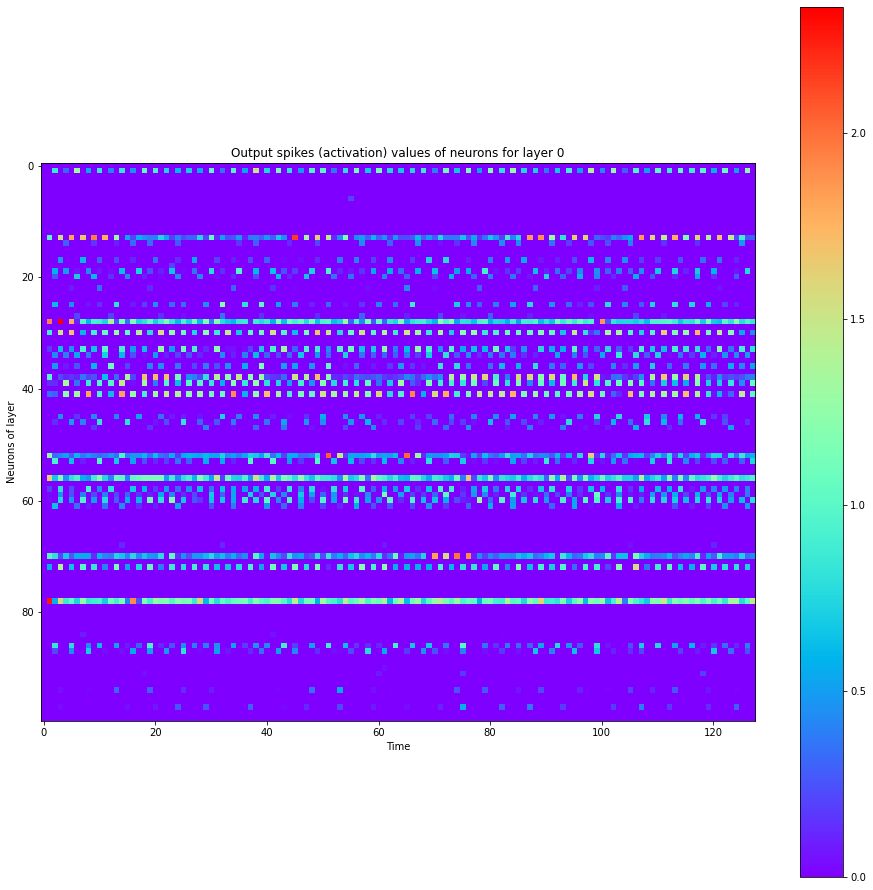

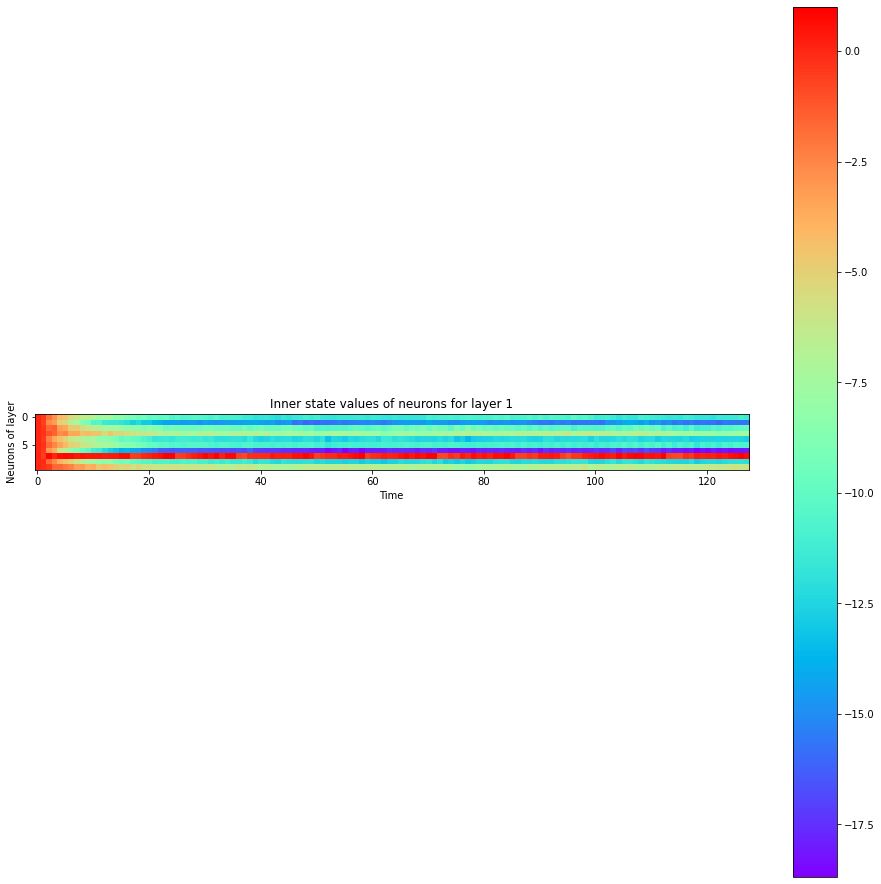

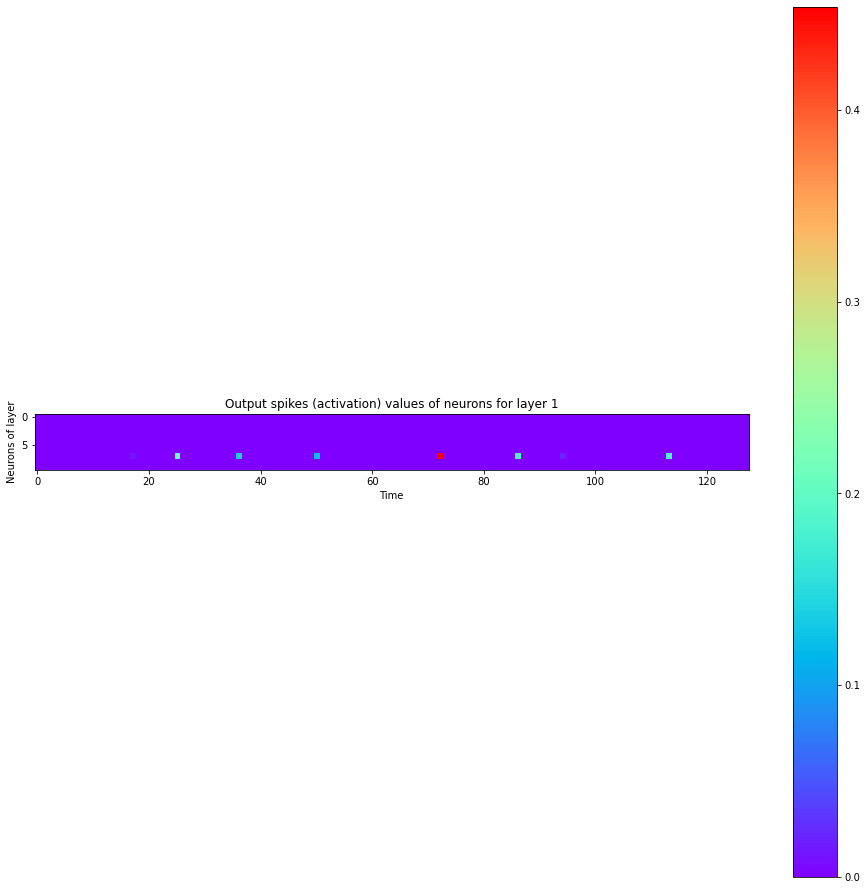

A hidden neuron that looks excited : 


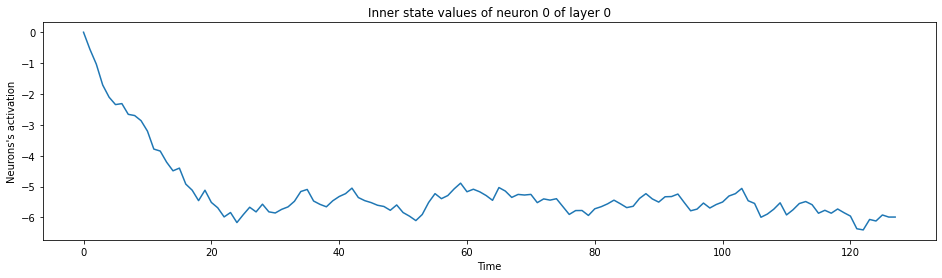

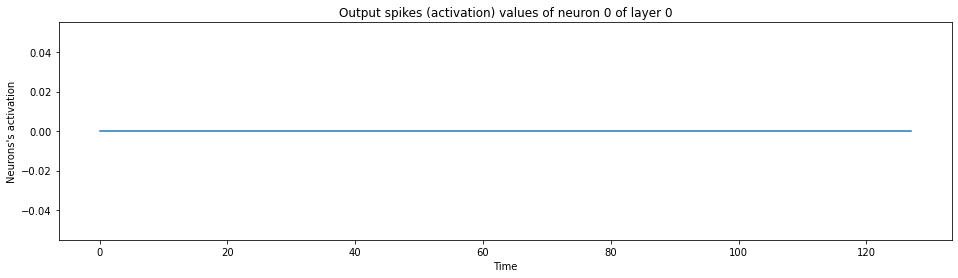

The output neuron of label : 


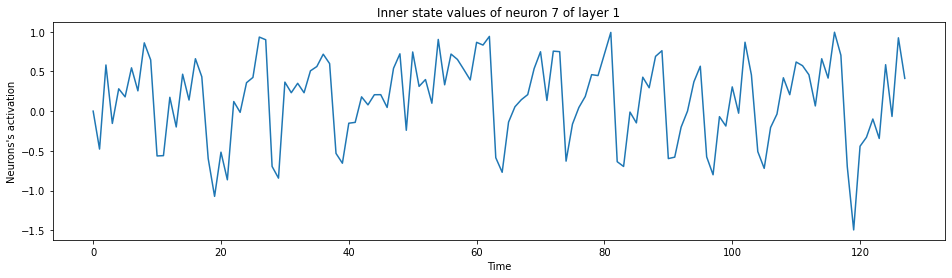

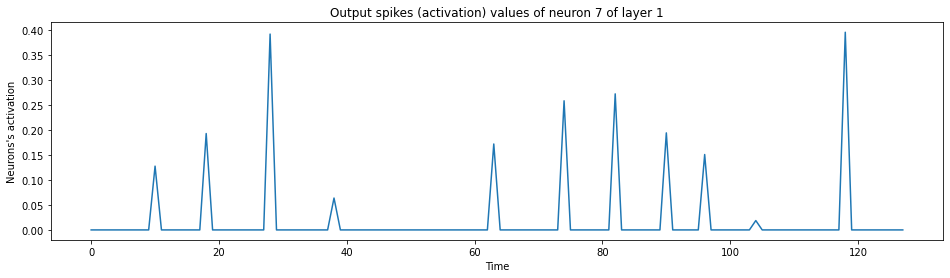

In [3]:
bs = 1000
DATA_PATH = './data' 

# GPU if there
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else "cpu")

def train(model, device , train_set_loader, optimizer, epoch, logging_interval = 100):

    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0 :
            pred = output.max(1, keepdim = True)[1] # getting index of max log prob
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print("Train Epoch : {} [{}/{} ({:.0f}%)] Loss : {:.6f} Accuracy : {:.2f}%".format(
                epoch, batch_idx * len(data) , len(train_set_loader.dataset),
                100. * batch_idx/ len(train_set_loader), loss.item(), 
                100. * correct))
            
def train_many_epochs(model):
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)


def test(model, device, test_set_loader): 

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce = True).item() # sum up batch loss
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader)
    print("")
    print("Test set : Average Loss : {:.4f}, Accuracy : {}/{} ({:.2f}%) ".format(
        test_loss,
        correct,len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")



train_set,test_set = download_mnist(DATA_PATH)

train_set_loader = torch.utils.data.DataLoader(
        dataset = train_set,
        batch_size = bs,
        shuffle = True)

test_set_loader = torch.utils.data.DataLoader(
        dataset = test_set,
        batch_size = bs,
        shuffle = False)



spiking_model = SpikingNet(device = device, n_time_steps = 128, begin_eval = 0)
train_many_epochs(spiking_model)

non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model)


# Visualzing
data,target = test_set_loader.__iter__().__next__()

# taking 1st testing example
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize = (12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image of x of label y = {}:".format(y))
plt.show()

# Plotting neuron's activations
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited : ")
spiking_model.visualize_neuron(x,layer_idx = 0, neuron_idx = 0)
print("The output neuron of label : ")
spiking_model.visualize_neuron(x,layer_idx = 1, neuron_idx = y)



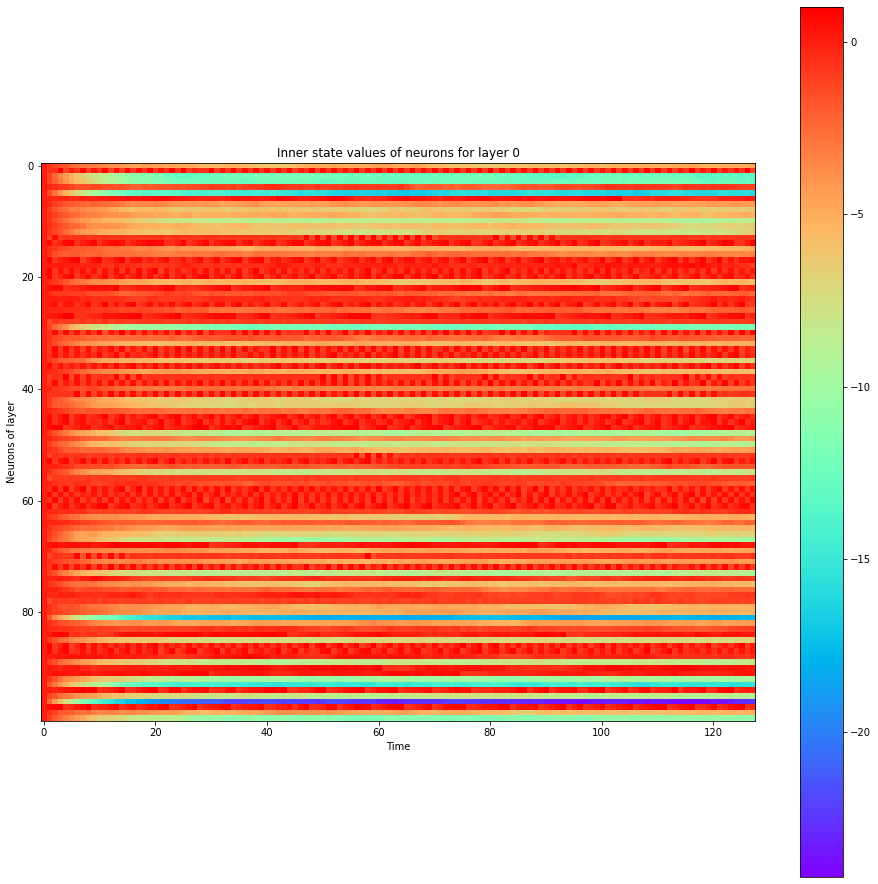

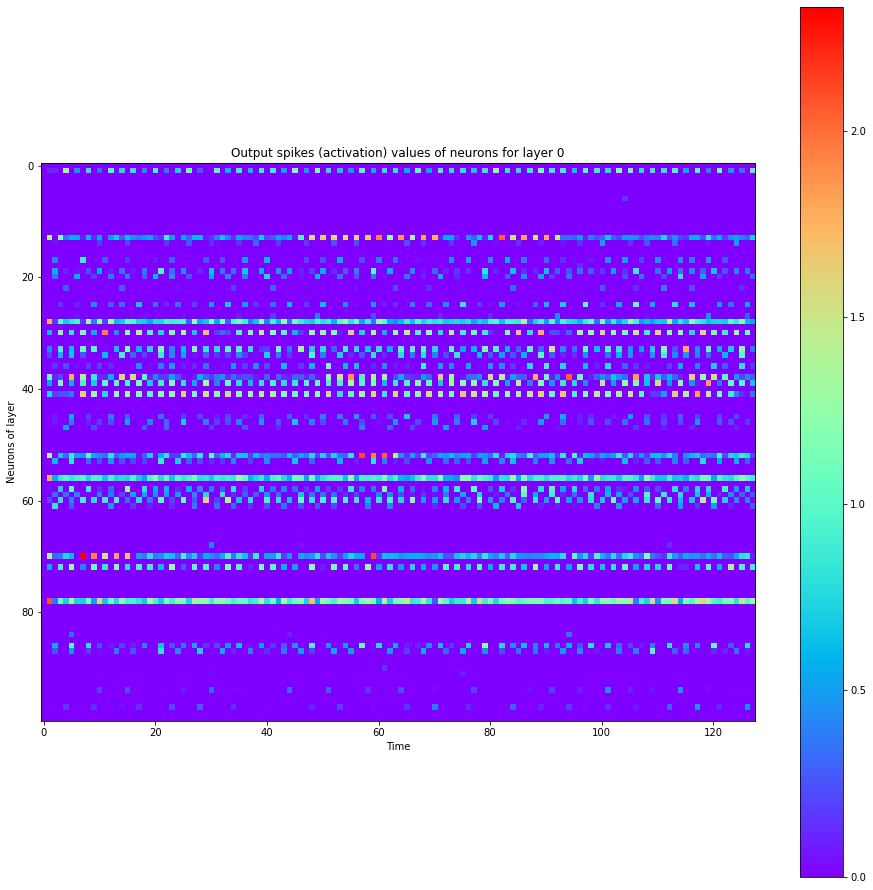

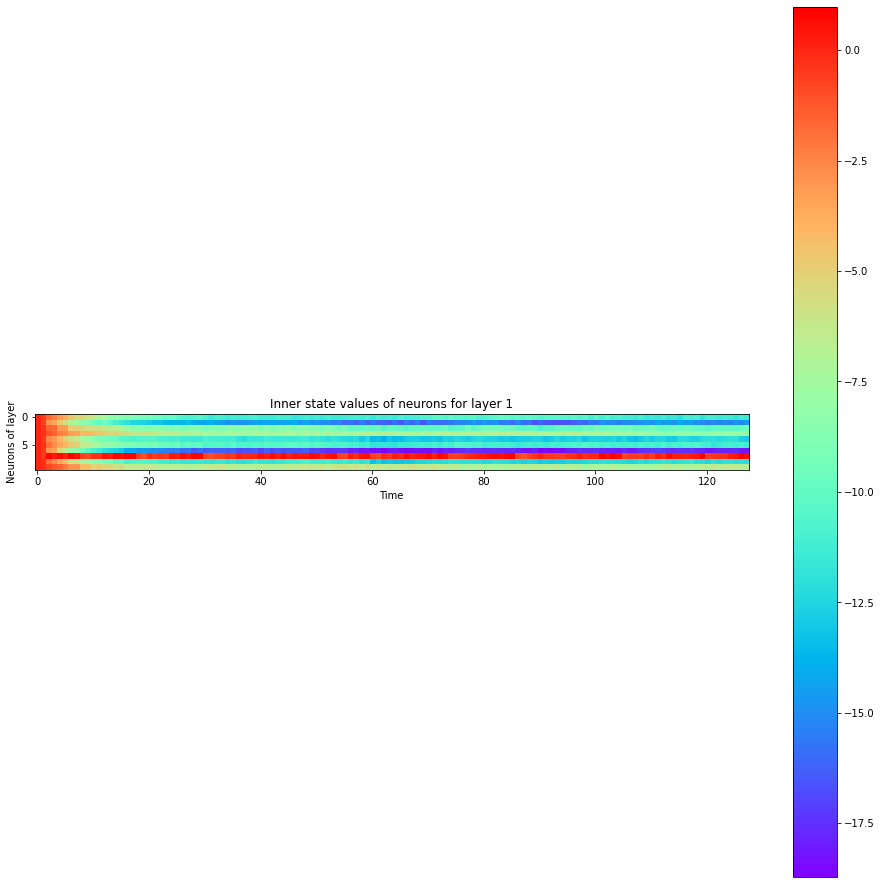

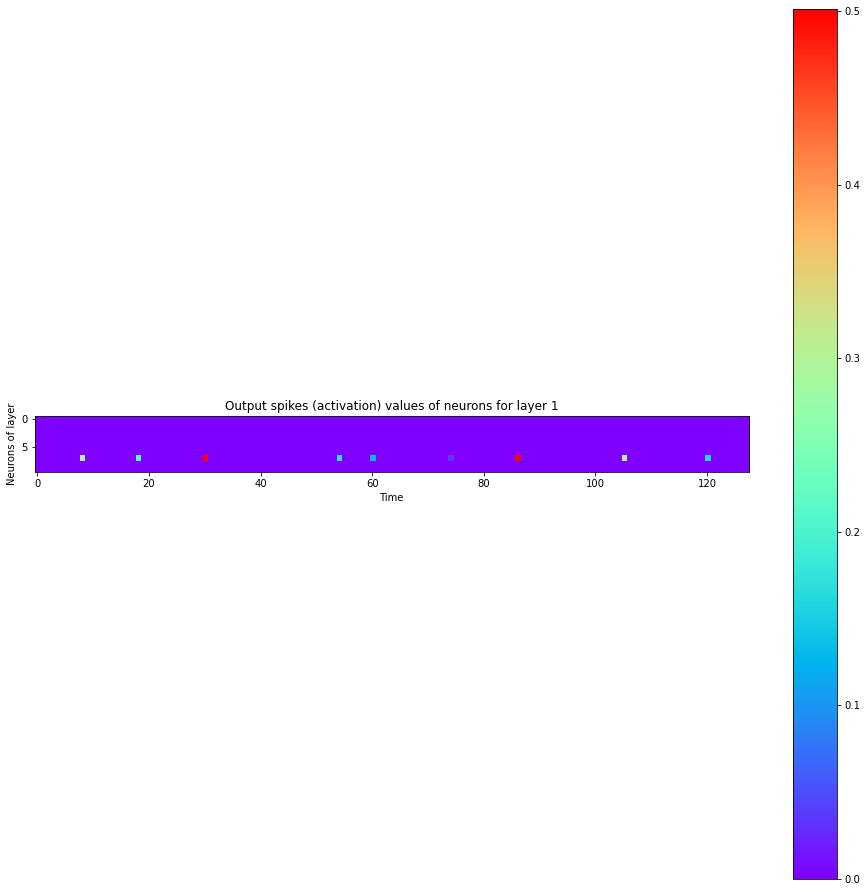

A hidden neuron that looks excited : 


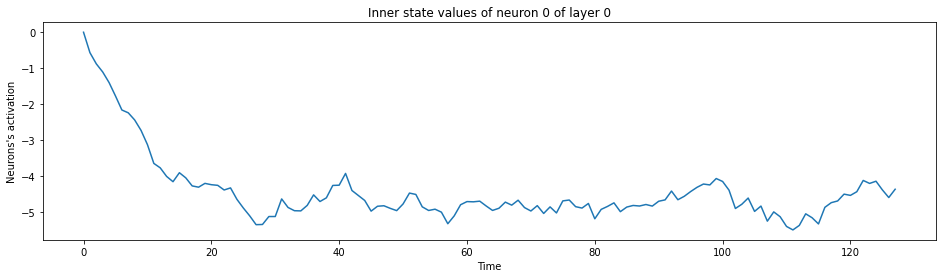

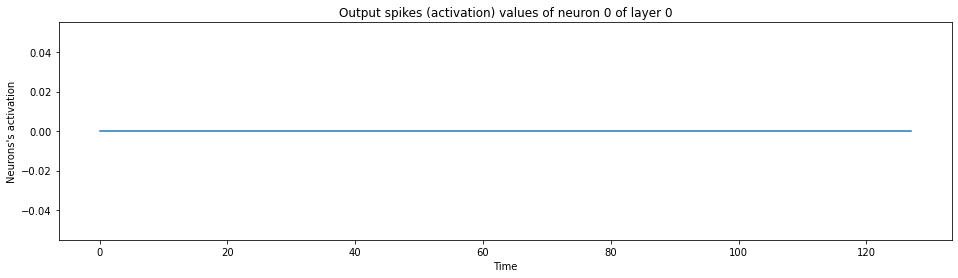

The output neuron of label : 


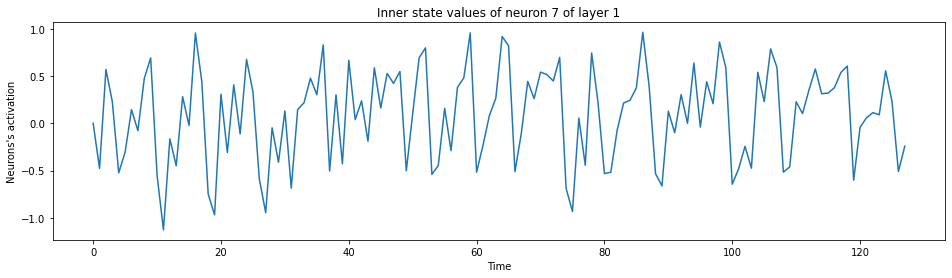

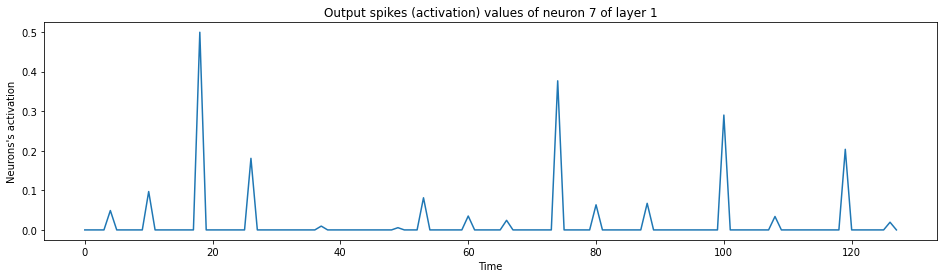

In [4]:
# Plotting neuron's activations
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited : ")
spiking_model.visualize_neuron(x,layer_idx = 0, neuron_idx = 0)
print("The output neuron of label : ")
spiking_model.visualize_neuron(x,layer_idx = 1, neuron_idx = y)